# Finding the shortest path in an amusement park

## Section 1 : Setup and moving functions

In [1]:
# import 
import cv2
import tkinter as tk
from tkinter.simpledialog import askstring
import os
import subprocess
import numpy as np 
import sys
import pandas as pd
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Function to update the image with last infos
#--------------------------------------------------------------------------------------------------------

def update_display():

    '''
    The aim of this is to update the image size.
    '''

    #--------------------------------------------------------------------------------------------------------
    
    global actual_image # The actual image with the previously added points in red
    global current_zoom, x_offset, y_offset # The zoom parameters
    
    #--------------------------------------------------------------------------------------------------------

    # We zoom on the original image 
    zoomed_image = cv2.resize(actual_image.copy(), None, fx=current_zoom, fy=current_zoom, interpolation=cv2.INTER_LINEAR)

    #--------------------------------------------------------------------------------------------------------
    
    # Calculate the maximum allowable offsets to avoid going out of bounds (the program crahses and return an error in this case)
    max_x_offset = max(zoomed_image.shape[1] - actual_image.shape[1], 0)
    max_y_offset = max(zoomed_image.shape[0] - actual_image.shape[0], 0)

    #--------------------------------------------------------------------------------------------------------
    
    # Limit x_offset and y_offset to stay within bounds
    x_offset = max(0, min(x_offset, max_x_offset))
    y_offset = max(0, min(y_offset, max_y_offset))

    #--------------------------------------------------------------------------------------------------------
    
    # Apply offsets to simulate movement
    zoomed_image = zoomed_image[y_offset:y_offset + actual_image.shape[0], x_offset:x_offset + actual_image.shape[1]]
    
    # Displays what has been done to this point 
    cv2.imshow('Image', zoomed_image)

In [3]:
# Functions to zoom in the image 
#------------------------------------------------------------------------------------------------------------------

def zoom_in():
    
    '''
    This is a function to zoom in the map. 
    '''
    
    global current_zoom, zoom_factor # The zoom parameters
    
    current_zoom *= zoom_factor # Updates the currrent zoom
    
    update_display() # Updates the window of the actual image
    
#------------------------------------------------------------------------------------------------------------------

def zoom_out():
    
    '''
    This is a function to zoom out the map. 
    '''
    
    global current_zoom, zoom_factor # The zoom parameters
    
    current_zoom /= zoom_factor # Updates the currrent zoom
    
    update_display() # Updates the window of the actual image

In [4]:
# Function to move on the zoomed map
#------------------------------------------------------------------------------------------------------------------

def move(direction):
    
    '''
    This is a function to move on the zoomed map.
    '''
    
    global x_offset, y_offset, move_step # The movement parameters
    
    #------------------------------------------------------------------------------------------------------------------
    # To move up on the zoomed map
    if direction == 'up':
        y_offset -= move_step
        
    #------------------------------------------------------------------------------------------------------------------
    # To move down on the zoomed map   
    elif direction == 'down':
        y_offset += move_step
        
    #------------------------------------------------------------------------------------------------------------------
    # To move left on the zoomed map    
    elif direction == 'left':
        x_offset -= move_step
        
    #------------------------------------------------------------------------------------------------------------------
    # To move right on the zoomed map   
    elif direction == 'right':
        x_offset += move_step
        
    #------------------------------------------------------------------------------------------------------------------
        
    update_display()

## Adding points on the map

In [5]:
# Function to add a point
#--------------------------------------------------------------------------------------------------------

def add_point(event, x, y, flags, param):

    '''
    The aim of this function is to add a point on the loaded image. The added point will be a node and should be an interest point on the map.

    Arg :
    event : An action defined in cv2. Here it is the right click to add a point. 
    x,y : The position of the point in the current window (as we allow zoom).
    flags,param : not used, mandatory to use this function
    
    '''
    global actual_image # The actual image with the previously added points in red
    global final # The final image with all ever added points
    
    global all_points # The dictionnary of all ever added points
    
    global x_offset, y_offset, current_zoom # The zoom parameters

    # When the right click is pressed 
    if event == cv2.EVENT_RBUTTONDOWN:

        #--------------------------------------------------------------------------------------------------------

        # Store the point in the original image coordinates (as we're working on a zommed window)
        original_x = int((x + x_offset) / current_zoom)
        original_y = int((y + y_offset) / current_zoom)

        #--------------------------------------------------------------------------------------------------------
        
        # Create a Tkinter root window (hidden). Mean window of the program
        root = tk.Tk()
        root.withdraw()

        #--------------------------------------------------------------------------------------------------------
        
        # Display an input dialog to enter the name for the point
        point_name = askstring("Point Name", "Enter a name for the point:")

        #--------------------------------------------------------------------------------------------------------
        
        # Check if a name was entered
        if point_name:
            
            # We add a red circle at pointed point on the actual image
            cv2.circle(actual_image, (original_x, original_y), 5, (0, 0, 255), -1)
            
            # We add a blue circle at pointed point on the final image
            cv2.circle(final, (original_x, original_y), 5, (255, 0, 0), -1)
            
            # Store the point and its coordinates in the dictionaries of the names
            all_points[point_name] = (original_x,original_y)

        #--------------------------------------------------------------------------------------------------------
        
        # We replace the previous version of the images with the new one with our new point
        cv2.imwrite('Map_with_red_points.JPG', actual_image)
        cv2.imwrite('Map_with_blue_points.JPG', final)

        # Destroy the root window
        root.destroy()

        #--------------------------------------------------------------------------------------------------------

        # Update the image using our function defined above
        update_display()

In [6]:
# Mean part of the code to add points 
#------------------------------------------------------------------------------------------------------------------

# We define a dict that will contain all ever added points and their position
all_points = {}

#------------------------------------------------------------------------------------------------------------------

# We load the original image and make a copy of it on which we'll add points 
original_image = cv2.imread('Map.JPG')

# Create a copy of the original that we will update with temporary red points
temporary = original_image.copy()
cv2.imwrite('Map_with_red_points.JPG', temporary)

# Create a copy of the original that we will update with all ever added blue points
final = original_image.copy()
cv2.imwrite('Map_with_blue_points.JPG', final)

#------------------------------------------------------------------------------------------------------------------

boo = True
while boo :  

    #------------------------------------------------------------------------------------------------------------------

    # Zoom parameters
    zoom_factor = 1.2  # You can adjust the zoom factor
    current_zoom = 1.0 # Must be initialized at 1 

    # Movement parameters
    x_offset = 0 # Must be initialized at 0
    y_offset = 0 # Must be initialized at 0
    
    move_step = 30 # You can adjust the movement factor

    #------------------------------------------------------------------------------------------------------------------

    # Load your JPEG image
    actual_image = cv2.imread('Map_with_blue_points.JPG')

    #------------------------------------------------------------------------------------------------------------------

    # Create a window and set the mouse callback function
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', add_point)

    #------------------------------------------------------------------------------------------------------------------
    
    # Displays what has been done to this point 
    cv2.imshow('Image', actual_image)

    while True:        

        #------------------------------------------------------------------------------------------------------------------

        # Wait for user to add points and press a key
        key = cv2.waitKey(1) & 0xFF

        if key == ord('p'): # You finished part of the points
            break
        
        elif key == ord('+'): # To zoom in 
            zoom_in()
            
        elif key == ord('-'): # To zoom out
            zoom_out()
            
        elif key == ord('w') : # To move down
            move('down')
            
        elif key ==  ord('z'): # To move up
            move('up')
            
        elif key == ord('q') : # To move left
            move('left')
            
        elif key ==  ord('s'): # To move right
            move('right')

        elif key == ord('y'): # You finished adding all your points
            boo = False 
            break 

    #------------------------------------------------------------------------------------------------------------------

    cv2.destroyAllWindows()

#------------------------------------------------------------------------------------------------------------------

# Print all points with their names
for name, location in all_points.items():
    print(f"Name: {name}, Location: {location}")

#------------------------------------------------------------------------------------------------------------------
# And write them in an external file 

# Specify the name of the output text file
output_file = "points.txt"

# Open the file in write mode to write all names
with open(output_file, "w") as file:
    for name, location in all_points.items():
        file.write(str(name) + ';' + str(location) + '\n')

Name: lion, Location: (387, 170)
Name: pandas, Location: (287, 282)
Name: snake, Location: (523, 232)
Name: tiger, Location: (791, 214)
Name: bear, Location: (912, 477)
Name: rhino, Location: (326, 160)


In [7]:
# Just to rename the files for more 

if os.path.isfile('Map_with_points.JPG'):
    os.remove('Map_with_points.JPG')
os.rename('Map_with_blue_points.JPG', 'Map_with_points.JPG')
os.remove('Map_with_red_points.JPG')

## Adding paths between the nodes

In [8]:
def calculate_curve_length(curve_points):
    
    '''
    This function computes the "length" of a curve on the map. 
    
    Arguments : 
    points : all the successive points of the curve available
    '''
    
    # Compute the length of the curve using numerical integration (segment wise) 
    length = 0
    
    for i in range(1, len(curve_points)):
        
        x1, y1 = curve_points[i - 1]
        x2, y2 = curve_points[i]
        
        segment_length = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        
        length += segment_length
        
    return length

In [9]:
def endpoints():
    
    '''This function asks the user to select the 2 endpoints of the curve among the nodes'''
    
    #------------------------------------------------------------------------------------------------------------------
    # Extract the names
    
    def read_names_from_file(filename):
        with open(filename, 'r') as file:
            return [line.strip().split(';')[0] for line in file]

    #------------------------------------------------------------------------------------------------------------------
    # Validation of the choices 
    
    def validation():
        # Add the selected names to the 'selected_names' array
        selected_names.append(name_var.get())
        selected_names.append(name_var2.get())
        root.destroy()  # Close the Tkinter window gracefully
        
    #------------------------------------------------------------------------------------------------------------------
    # Cancel 
    
    def cancel():
        root.destroy()  # Close the Tkinter window gracefully
        
    #------------------------------------------------------------------------------------------------------------------

    # Read names from the text file (modify the filename as needed)
    names_list = read_names_from_file('points.txt')

    root = tk.Tk()
    root.title("Choose Endpoints")

    # Create an empty array to store the selected names
    selected_names = []
    
    #------------------------------------------------------------------------------------------------------------------

    # "From" text
    to_label = tk.Label(root, text="From:")
    to_label.pack()
    
    #------------------------------------------------------------------------------------------------------------------

    # Create a placeholder for the first dropdown menu
    name_var = tk.StringVar(root)
    name_var.set("Select a name")  # Placeholder text
    name_dropdown = tk.OptionMenu(root, name_var, *names_list)
    name_dropdown.pack(pady=10)
    
    #------------------------------------------------------------------------------------------------------------------

    # "To" text
    to_label = tk.Label(root, text="To:")
    to_label.pack()
    
    #------------------------------------------------------------------------------------------------------------------

    # Create the second dropdown menu
    name_var2 = tk.StringVar(root)
    name_var2.set("Select a name")  # Placeholder text
    name_dropdown2 = tk.OptionMenu(root, name_var2, *names_list)
    name_dropdown2.pack(pady=10)
    
    #------------------------------------------------------------------------------------------------------------------

    # Create a "validation" button
    validation_button = tk.Button(root, text="Validate", command=validation)
    validation_button.pack(pady=10)
    
    #------------------------------------------------------------------------------------------------------------------
    
    # Create a "cancel" button
    cancel_button = tk.Button(root, text="Cancel", command=cancel)
    cancel_button.pack(pady=10)
    
    #------------------------------------------------------------------------------------------------------------------

    root.mainloop()

    # Now the selected names are stored in the 'selected_names' array
    return selected_names

In [10]:
def draw_curve(event, x, y, flags, param):
    
    '''
    The aim of this function is to add a point on the loaded image. The added point will be a node and should be an interest point on the map.

    Arg :
    event : An action defined in cv2. Here it is the right click to add a point. 
    x,y : The position of the point in the current window (as we allow zoom).
    flags,param : not used, mandatory to use this function
    
    '''
    
    global drawing # A boolean to see if we're holding the button
    global points # An empty list that will contain points of the curves. Must be global
    global actual_image # The image on which we'll draw red curves
    global count # Numbering the curves allows us to have multiple edges between the same endpoints
    global all_curves, Curves
    
    #------------------------------------------------------------------------------------------------------------------

    # We start by clicking on the left button
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        points = [(x, y)]

    #------------------------------------------------------------------------------------------------------------------

    # We move the mouse to draw the curve
    elif event == cv2.EVENT_MOUSEMOVE:
        
        if drawing: # You must hold the left button
            
            points.append((x, y)) # Keep track of the points among the path
            
            for i in range(1, len(points)):
                
                cv2.line(actual_image, points[i - 1], points[i], (0, 0, 255), 2) # To draw the red curve on the image
                
            cv2.imwrite('Map_with_curves.JPG', actual_image)

    #------------------------------------------------------------------------------------------------------------------
    
    # When we don't hold the button anymore
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

        ends = endpoints() # The endpoints are asked to the user
        
        if len(ends) == 2:
 
            name = (count, ends[0], ends[1]) # Give a name to the curve with its number and the ends
            count += 1
            
            all_curves.append(points)
            Curves[name] = calculate_curve_length(points) # Computes the length and add an entry in the dic

In [11]:
# Mean part of the code to add curves
#------------------------------------------------------------------------------------------------------------------

all_curves = []
Curves = {} 

# To store points along the path
points = []

#------------------------------------------------------------------------------------------------------------------

# Loads the images with points and make a copy on which we'll add curves 
original_image = cv2.imread('Map_with_points.JPG')
actual_image = original_image.copy()
cv2.imwrite('Map_with_curves.JPG', actual_image)

#------------------------------------------------------------------------------------------------------------------

boo = True
drawing = False  # True if mouse button is pressed
count = 1 

#------------------------------------------------------------------------------------------------------------------

# Create a window and set the mouse callback function
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', draw_curve)

#------------------------------------------------------------------------------------------------------------------

boo = True 
while boo:
    
    #------------------------------------------------------------------------------------------------------------------

    # Zoom parameters
    zoom_factor = 1.2  # You can adjust the zoom factor
    current_zoom = 1.0 # Must be initialized at 1 

    # Movement parameters
    x_offset = 0 # Must be initialized at 0
    y_offset = 0 # Must be initialized at 0
    
    move_step = 30 # You can adjust the movement factor

    #------------------------------------------------------------------------------------------------------------------

    # Load your JPEG image
    actual_image = cv2.imread('Map_with_curves.JPG')

    #------------------------------------------------------------------------------------------------------------------
    
    while True:
        
        cv2.imshow('Image', actual_image)
        
        # Wait for user to add points and press a key
        key = cv2.waitKey(1) & 0xFF

        if key == ord('p'): # You finished part of the points
            break
        
        elif key == ord('+'): # To zoom in 
            zoom_in()
            
        elif key == ord('-'): # To zoom out
            zoom_out()
            
        elif key == ord('w') : # To move down
            move('down')
            
        elif key ==  ord('z'): # To move up
            move('up')
            
        elif key == ord('q') : # To move left
            move('left')
            
        elif key ==  ord('s'): # To move right
            move('right')

        elif key == ord('y'): # You finished adding all your points
            boo = False 
            break 

    #------------------------------------------------------------------------------------------------------------------

    # Save the final image with the curves
    for curve in all_curves:
        for i in range(1, len(curve)):
            cv2.line(original_image, curve[i - 1], curve[i], (255, 0, 0), 2)

    cv2.imwrite('Map_with_curves.JPG', original_image)

    #------------------------------------------------------------------------------------------------------------------

cv2.destroyAllWindows()

#------------------------------------------------------------------------------------------------------------------

# Print the edges and their lengths 
for ends, length in Curves.items():
    print(f"Ends: {ends}, Length: {length}")

#------------------------------------------------------------------------------------------------------------------

# Specify the name of the output text file
output_file = "curves.txt"

# Open the file in write mode
with open(output_file, "w") as file:
    for ends, length in Curves.items():
        file.write(str(ends[0]) + ';' + ends[1] + ',' + ends[2] + ';' + str(length) + '\n') # Write the curves in a txt file

Ends: (1, 'lion', 'pandas'), Length: 159.2360375087829
Ends: (2, 'rhino', 'lion'), Length: 59.073627243117684
Ends: (3, 'pandas', 'rhino'), Length: 135.30158940834724
Ends: (4, 'snake', 'lion'), Length: 152.60354022404928
Ends: (5, 'snake', 'tiger'), Length: 271.9249933851742
Ends: (6, 'bear', 'tiger'), Length: 301.255496912857
Ends: (7, 'snake', 'bear'), Length: 468.08019802052246
Ends: (8, 'snake', 'lion'), Length: 202.36757948638922


## Translating into graphs

In [12]:
# Read node data from file 
# The result is dic with the name and their position 

with open('points.txt', 'r') as f:
    
    nodes = {}
    
    for line in f.readlines():
        
        name, location_part = line.strip().split(';')
        location = location_part.strip()[1:-1].split(',')
        location = (int(location[0]), -1 * int(location[1]))  # -1 because the ref is the top left corner
        nodes[name] = location

#------------------------------------------------------------------------------------------------------------------

already = [] 

# Read edge data from file
with open('curves.txt', 'r') as f:
    
    edges = {}
    
    for line in f.readlines():
        
        #------------------------------------------------------------------------------------------------------------------
        # Retrieve the informations of the edge
        
        num, ends_part, length = line.strip().split(';')

        length = round(float(length), 3)

        node1, node2 = ends_part.strip().split(',')
        
        #------------------------------------------------------------------------------------------------------------------
        # Creates a tuple. As the edge is a road that could be taken in both direction, both edges must be checked

        edge = (node1,node2)
        edge_bis = (node2, node1)

        #------------------------------------------------------------------------------------------------------------------
        # If none direction is already in the list, we add an entry in the dic with the length and add it to the list 
        
        if edge not in already and edge_bis not in already : 
            edges[edge] = float(length)
            already.append(edge)

        #------------------------------------------------------------------------------------------------------------------
        # If there's already in the list, we check if the new edge considered as a length lower than the previous one 
        # If it's the case, we replace the length in the dictionnary
        
        else :
            if edge in already : 
                if length < edges[edge] : 
                    edges[edge] = length
            if edge_bis in already : 
                if length < edges[edge_bis] : 
                    edges[edge_bis] = length 

#------------------------------------------------------------------------------------------------------------------
# Create distance matrix between the nodes 

names = [] 
for name in nodes.keys() : 
    names.append(name)

dists = [[0]*len(nodes) for _ in range(len(nodes))]

for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):

        edge = (names[i], names[j])
        edge_bis = (names[j], names[i])

        if edge in edges.keys() :
            dists[i][j] = edges[edge]
            dists[j][i] = edges[edge]
            
        elif edge_bis in edges.keys() : 
            dists[i][j] = edges[edge_bis]
            dists[j][i] = edges[edge_bis]
            
        else : 
            dists[i][j] = float('inf')
            dists[j][i] = float('inf')

#------------------------------------------------------------------------------------------------------------------

# Create a DataFrame from the distance matrix
df = pd.DataFrame(dists, columns=names, index=names)

# Display the DataFrame
print()
print("Shorter direct access between the points (symmetric) \n")
print(df)


Shorter direct access between the points (symmetric) 

           lion   pandas    snake    tiger     bear    rhino
lion      0.000  159.236  152.604      inf      inf   59.074
pandas  159.236    0.000      inf      inf      inf  135.302
snake   152.604      inf    0.000  271.925  468.080      inf
tiger       inf      inf  271.925    0.000  301.255      inf
bear        inf      inf  468.080  301.255    0.000      inf
rhino    59.074  135.302      inf      inf      inf    0.000


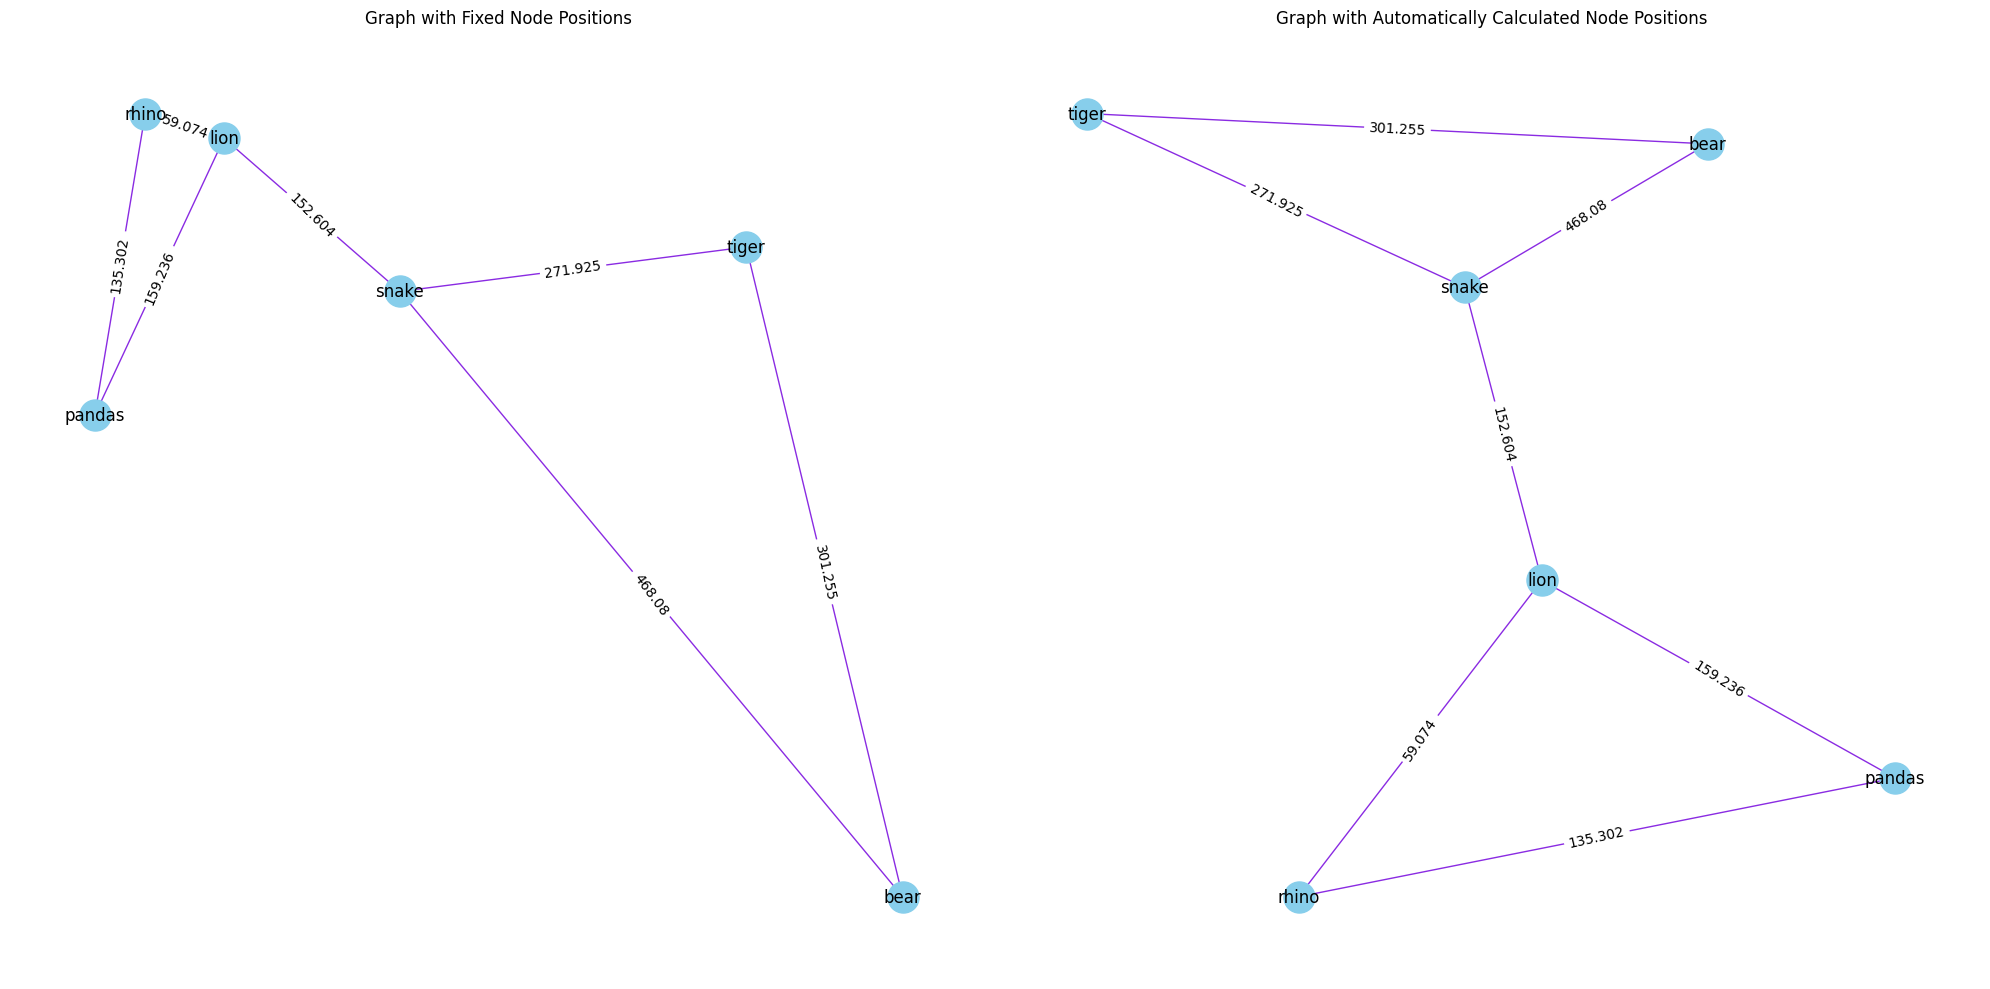

<Figure size 640x480 with 0 Axes>

In [13]:
# Create an empty graph
G = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        if dists[i][j] != float('inf'):  # Only add an edge if a distance exists
            G.add_edge(names[i], names[j], weight=dists[i][j])

# Get node positions from the graph
node_positions = {node: data['pos'] for node, data in G.nodes(data=True)}

# Create dictionaries for node and edge labels
node_labels = {node: node for node in G.nodes()}
edge_labels = {(u, v): round(data['weight'], 3) for u, v, data in G.edges(data=True)}

#------------------------------------------------------------------------------------------------------------------

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

#------------------------------------------------------------------------------------------------------------------

# Draw the graph with fixed node positions
position = nx.spring_layout(G, pos=node_positions, fixed=node_positions.keys())
nx.draw_networkx_nodes(G, position, node_color='skyblue', node_size=500, ax=axs[0])
nx.draw_networkx_edges(G, position, edge_color='blueviolet', ax=axs[0])
nx.draw_networkx_labels(G, position, labels=node_labels, font_size=12, font_color='black', ax=axs[0])
nx.draw_networkx_edge_labels(G, position, edge_labels=edge_labels, font_size=10, ax=axs[0])
axs[0].set_title('Graph with Fixed Node Positions')
axs[0].axis('off')

#------------------------------------------------------------------------------------------------------------------

# Draw the graph with automatically calculated node positions
position = nx.spring_layout(G)
nx.draw_networkx_nodes(G, position, node_color='skyblue', node_size=500, ax=axs[1])
nx.draw_networkx_edges(G, position, edge_color='blueviolet', ax=axs[1])
nx.draw_networkx_labels(G, position, labels=node_labels, font_size=12, font_color='black', ax=axs[1])
nx.draw_networkx_edge_labels(G, position, edge_labels=edge_labels, font_size=10, ax=axs[1])
axs[1].set_title('Graph with Automatically Calculated Node Positions')
axs[1].axis('off')

#------------------------------------------------------------------------------------------------------------------

# Display the graphs
plt.tight_layout()
plt.show()
plt.savefig('Graph_result.pdf')

## Start of optimization

In [14]:
# A try for Christofides algorithm (still doesn't work)
#------------------------------------------------------------------------------------------------------------------

import networkx.algorithms.approximation as nx_app

node1, node2 = 'hippo', 'bear'

G_complete = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G_complete.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        G_complete.add_edge(names[i], names[j], weight=dists[i][j])
            
print(nx_app.christofides(G_complete))

['lion', 'snake', 'tiger', 'bear', 'pandas', 'rhino', 'lion']


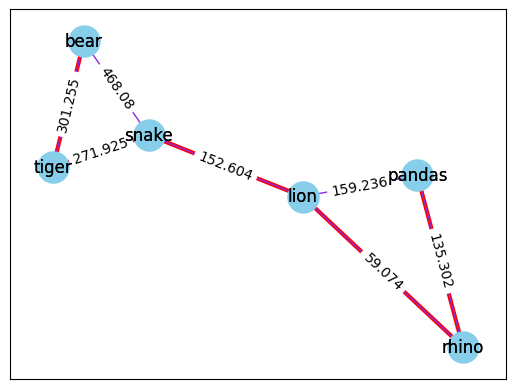

In [15]:
# Kruskal to find the minimum spanning edges tree using kruskal, prim or brunovsky

from networkx.algorithms import tree
mst = tree.minimum_spanning_edges(G_complete, algorithm='kruskal')
edgelist = list(mst)

# Create an empty graph
G_kruskal = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G_kruskal.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        if dists[i][j] != float('inf'):  # Only add an edge if a distance exists
            G_kruskal.add_edge(names[i], names[j], weight=dists[i][j])
            
position = nx.spring_layout(G_kruskal)

# Create dictionaries for node and edge labels
node_labels = {node: node for node in G_kruskal.nodes()}
edge_labels = {(u, v): round(data['weight'], 3) for u, v, data in G_kruskal.edges(data=True)}

plt.figure()

# Draw the route
nx.draw_networkx(
    G_kruskal,
    position,
    with_labels=True,
    edgelist=edgelist,
    edge_color="red",
    node_size=200,
    width=3,
)

nx.draw_networkx_nodes(G_kruskal, position, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G_kruskal, position, edge_color='blueviolet')
nx.draw_networkx_labels(G_kruskal, position, labels=node_labels, font_size=12, font_color='black')
nx.draw_networkx_edge_labels(G_kruskal, position, edge_labels=edge_labels, font_size=10)

plt.show()

In [16]:
# A test for Dijkstra in Networkx
#------------------------------------------------------------------------------------------------------------------

import networkx as nx

def dijkstra(graph, start, end):
    # Use NetworkX's built-in Dijkstra's algorithm function
    length, path = nx.single_source_dijkstra(graph, start, end)
    
    return length, path

# Usage:
node1, node2 = names[0], names[-1]
length, path = dijkstra(G, node1, node2)
print(f"The shortest path from {node1} to {node2} is {path} with length {length}")


The shortest path from lion to rhino is ['lion', 'rhino'] with length 59.074


In [17]:
# Still in progress

import heapq

def modified_dijkstra(graph, start, end):
    
    n = len(graph)
    dist = [[float('inf')] * (1<<n) for _ in range(n)]
    prev = [[-1] * (1<<n) for _ in range(n)]
    
    dist[start][1<<start] = 0
    heap = [(0, start, 1<<start)]
    
    while heap:
        d, u, mask = heapq.heappop(heap)
        
        if d != dist[u][mask]:
            continue
        
        for v in range(n):
            if graph[u][v] is None:
                continue
            
            mask2 = mask | (1<<v)
            if dist[v][mask2] > dist[u][mask] + graph[u][v]:
                dist[v][mask2] = dist[u][mask] + graph[u][v]
                prev[v][mask2] = u
                heapq.heappush(heap, (dist[v][mask2], v, mask2))
    
    return build_path(prev, end, (1<<n)-1), dist[end][(1<<n)-1]

def build_path(prev, node, mask):
    if prev[node][mask] == -1:
        return [node]
    return build_path(prev, prev[node][mask], mask^(1<<node)) + [node]

print(modified_dijkstra(dists, 0, 0))

([1, 0], 1700.08)


In [18]:
# Still in progress

import itertools
import random
import sys


def held_karp(dists):
    """
    Implementation of Held-Karp, an algorithm that solves the Traveling
    Salesman Problem using dynamic programming with memoization.

    Parameters:
        dists: distance matrix

    Returns:
        A tuple, (cost, path).
    """
    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

print(held_karp(dists))

(inf, [0, 5, 4, 3, 2, 1])
